In [1]:
# using Pkg
# Pkg.activate("/home/jek354/research/ML-signproblem")
# Pkg.update()

using Lattices
using LinearAlgebra
using Combinatorics
using SparseArrays
using Plots
import Graphs
using LaTeXStrings
using Statistics
using Random
using Zygote
using Optimization, OptimizationOptimisers
using JSON
using OptimizationOptimJL
using ExponentialUtilities


include("ed_objects.jl")
include("ed_functions.jl")
include("ed_optimization.jl")
include("utility_functions.jl")

append_to_json_files (generic function with 1 method)

In [42]:
# using KrylovKit

t = 1.0
U = 6
μ = 0  # positive incentivises fewer particles (one electron costs this much energy)
# N_up = 2
# N_down = 2
N = 3
half_filling = false
# lattice = Chain(6, Periodic())
lattice_dimension = (2,3)
bc = "periodic"
# lattice = Chain(6, Periodic())
lattice = Square(lattice_dimension, if bc == "periodic" Periodic() else Open() end)
# lattice = Graphs.cycle_graph(3)

models = []

reference_index = 2
t_values = []# Float64[1,1], Float64[1,0.1], 1.0]
# for _t in t_values
#     # println(_t)
#     push!(models,HubbardModel(_t,0.0001,μ,half_filling))
# end
# U_values = [0.00001,0.01,0.2, 1,1.001,3,4,5,7,10, 100]
U_values = [0.00001; LinRange(2.1,9,20)]
U_values = sort([U_values; 10.0 .^LinRange(-3,2,40)])

for U in U_values
    # println(t)
    push!(models,HubbardModel(t,U,μ,half_filling))
end

subspace = HubbardSubspace(N, lattice)
# subspace = HubbardSubspace(N_up, N_down, lattice)

ops = []
push!(ops,Matrix(create_operator(subspace,:Sx)))
push!(ops, Matrix(create_operator(subspace,:S2)))
# op3 = Matrix(create_operator(subspace,:L2))
push!(ops, Matrix(create_operator(subspace,:T, kind=1)))
push!(ops, Matrix(create_operator(subspace,:T, kind=2)))
# push!(ops, Matrix(create_operator(subspace,:σ, kind=1)))
E = []
H = []
V = []
for model ∈ models
    push!(H, Matrix(create_Hubbard(model, subspace; perturbations=false)))
    e, v = eigen(H[end])
    push!(E, e)
    push!(V, v)
end

for i ∈ 1:2
    println(degeneracy_count(E[i]))
end

# println(sum(abs.(h1*h2-h2*h1)))
ops_tmp = [H[1], ops...]
for i in eachindex(ops_tmp)
    for j in i+1:length(ops_tmp)
        println("($i,$j) ", sum(abs.(ops_tmp[i]*ops_tmp[j] - ops_tmp[j]*ops_tmp[i])))
    end
end
# H1 = create_Hubbard(model, subspace; perturbations=false)
# E1 = diag(V1'*Matrix(H1)*V1)

@time degen_rm_U = create_consistent_basis(H, ops;reference_index=reference_index)

dim = get_subspace_dimension(subspace)
indexer = CombinationIndexer(reduce(vcat,collect(sites(subspace.lattice))), get_subspace_info(subspace)...)
difference_dict = collect_all_conf_differences(indexer)


Dict{Any, Any}(22 => 2, 4 => 32, 6 => 2, 2 => 2, 8 => 4)
Dict{Any, Any}(22 => 2, 4 => 26, 2 => 20, 8 => 4)
(1,2) 0.0
(1,3) 0.0
(1,4) 0.0
(1,5) 0.0
(2,3) 0.0
(2,4) 0.0
(2,5) 0.0
(3,4) 0.0
(3,5) 0.0
(4,5) 0.0
  4.471835 seconds (5.55 M allocations: 2.380 GiB, 36.70% gc time)


Dict{Any, Any} with 3 entries:
  2 => Dict{Tuple{Tuple{Set{Coordinate{2, Int64}}, Set{Coordinate{2, Int64}}}, …
  3 => Dict{Tuple{Tuple{Set{Coordinate{2, Int64}}, Set{Coordinate{2, Int64}}}, …
  1 => Dict{Tuple{Tuple{Set{Coordinate{2, Int64}}, Set{Coordinate{2, Int64}}}, …

In [3]:
# state = degen_rm_U[1][:,1]
args = correlation_matrix(1, indexer)
for i in axes(V[1][:,1:100],2)
    state1 = degen_rm_U[1][:,i]
    state2 = degen_rm_U[10][:,i]
    energy = real.(diag(degen_rm_U[10]'*H[10]*degen_rm_U[10])[i])
    println("state #:$i U=1 energy: $(energy) \t U=0,!=0 SD?:$(is_slater_determinant(state1, indexer; correlation_args=args)) $(is_slater_determinant(state2, indexer; correlation_args=args))   \t overlap: $(real(degen_rm_U[1][:,i]'*degen_rm_U[11][:,i]))")
end
# γ = compute_correlation(state, 1, indexer)
# println("rank(γ)=$(rank(γ))  sum(γ^2 -γ)=$(sum(abs.(γ^2-γ)))")
# eigvals(Matrix(mats[4,4]))

state #:1 U=1 energy: -0.9999999999999999 	 U=0,!=0 SD?:false false   	 overlap: 0.9999999999999998
state #:2 U=1 energy: 4.99999999999999 	 U=0,!=0 SD?:false false   	 overlap: 0.9999999999999987
state #:3 U=1 energy: 1.9999999999999993 	 U=0,!=0 SD?:false false   	 overlap: 1.0
state #:4 U=1 energy: -1.999999999999999 	 U=0,!=0 SD?:false false   	 overlap: 0.9999999999999993
state #:5 U=1 energy: 5.999999999999998 	 U=0,!=0 SD?:false false   	 overlap: 0.9999999999999994
state #:6 U=1 energy: -1.9999999999999991 	 U=0,!=0 SD?:false false   	 overlap: 1.0
state #:7 U=1 energy: -1.999999999999999 	 U=0,!=0 SD?:false false   	 overlap: 0.9999999999999996
state #:8 U=1 energy: 9.003539528580628 	 U=0,!=0 SD?:false false   	 overlap: 0.999999424173337
state #:9 U=1 energy: 6.003538769276423 	 U=0,!=0 SD?:false false   	 overlap: 0.9999989920423185
state #:10 U=1 energy: 3.0035384808404393 	 U=0,!=0 SD?:false false   	 overlap: 0.9999985464090413
state #:11 U=1 energy: -4.9982354689251745 

In [51]:
meta_data = Dict("electron count"=>3, "sites"=>"2x3", "bc"=>"periodic", "basis"=>"adiabatic", 
                "U_values"=>U_values, "maxiters"=>200)
instructions = Dict("starting state"=>Dict("U index"=>35, "levels"=>8),
                "ending state"=>Dict("U index"=>60, "levels"=>8), "max_order"=>1)
println(U_values[instructions["starting state"]["U index"]], " ", U_values[instructions["ending state"]["U index"]])
data_dict_tmp = test_map_to_state(degen_rm_U, instructions, indexer; maxiters=meta_data["maxiters"], optimization=:gradient)
data_dict_tmp["meta_data"] = meta_data
data_dict_tmp
# append_to_json_files(data_dict_tmp, "data/slater_determinant_unitary_N=3")

3.8881551803080883 74.43803013251689
magnitude: 0.19835900520528227
learning rate: 0.039671801041056456
  0.000097 seconds (651 allocations: 42.998 KiB)
  0.041655 seconds (472.61 k allocations: 54.476 MiB)
0.449159180884128
0.449159180884128
0.6180464316173707
0.6180464316173708
0.4104489480325181
0.4104489480325181
0.39996971453116226
0.39996971453116226
0.3983221547182618
0.3983221547182618
0.39739941141965984
0.39739941141965984
0.39721147678397173
0.39721147678397173
0.39688927280275743
0.39688927280275743
0.3966710713550595
0.3966710713550595
0.3962473204907385
0.3962473204907385
0.39399547275308666
0.39399547275308666
0.46880832751310886
0.46880832751310886
0.3930191568518734
0.3930191568518734
0.39208437697835286
0.39208437697835263
0.3912724480606953
0.3912724480606953
0.3875852228412867
0.3875852228412867
0.3767976691598762
0.376797669159876
0.37010567891148916
0.37010567891148916
0.33765002865007365
0.33765002865007343
0.33187898855545195
0.33187898855545195
0.30108880213236

Dict{String, Any} with 6 entries:
  "loss_std_metrics" => Any[Any[0.0, 1.80423e-6]]
  "loss_metrics"     => Any[Any[0.396718, 0.286627]]
  "meta_data"        => Dict{String, Any}("U_values"=>[1.0e-5, 0.001, 0.0013434…
  "labels"           => Any[Dict("starting state"=>Dict("U index"=>35, "level"=…
  "norm2_metrics"    => Any[[21.9342]]
  "norm1_metrics"    => Any[[1578.61]]

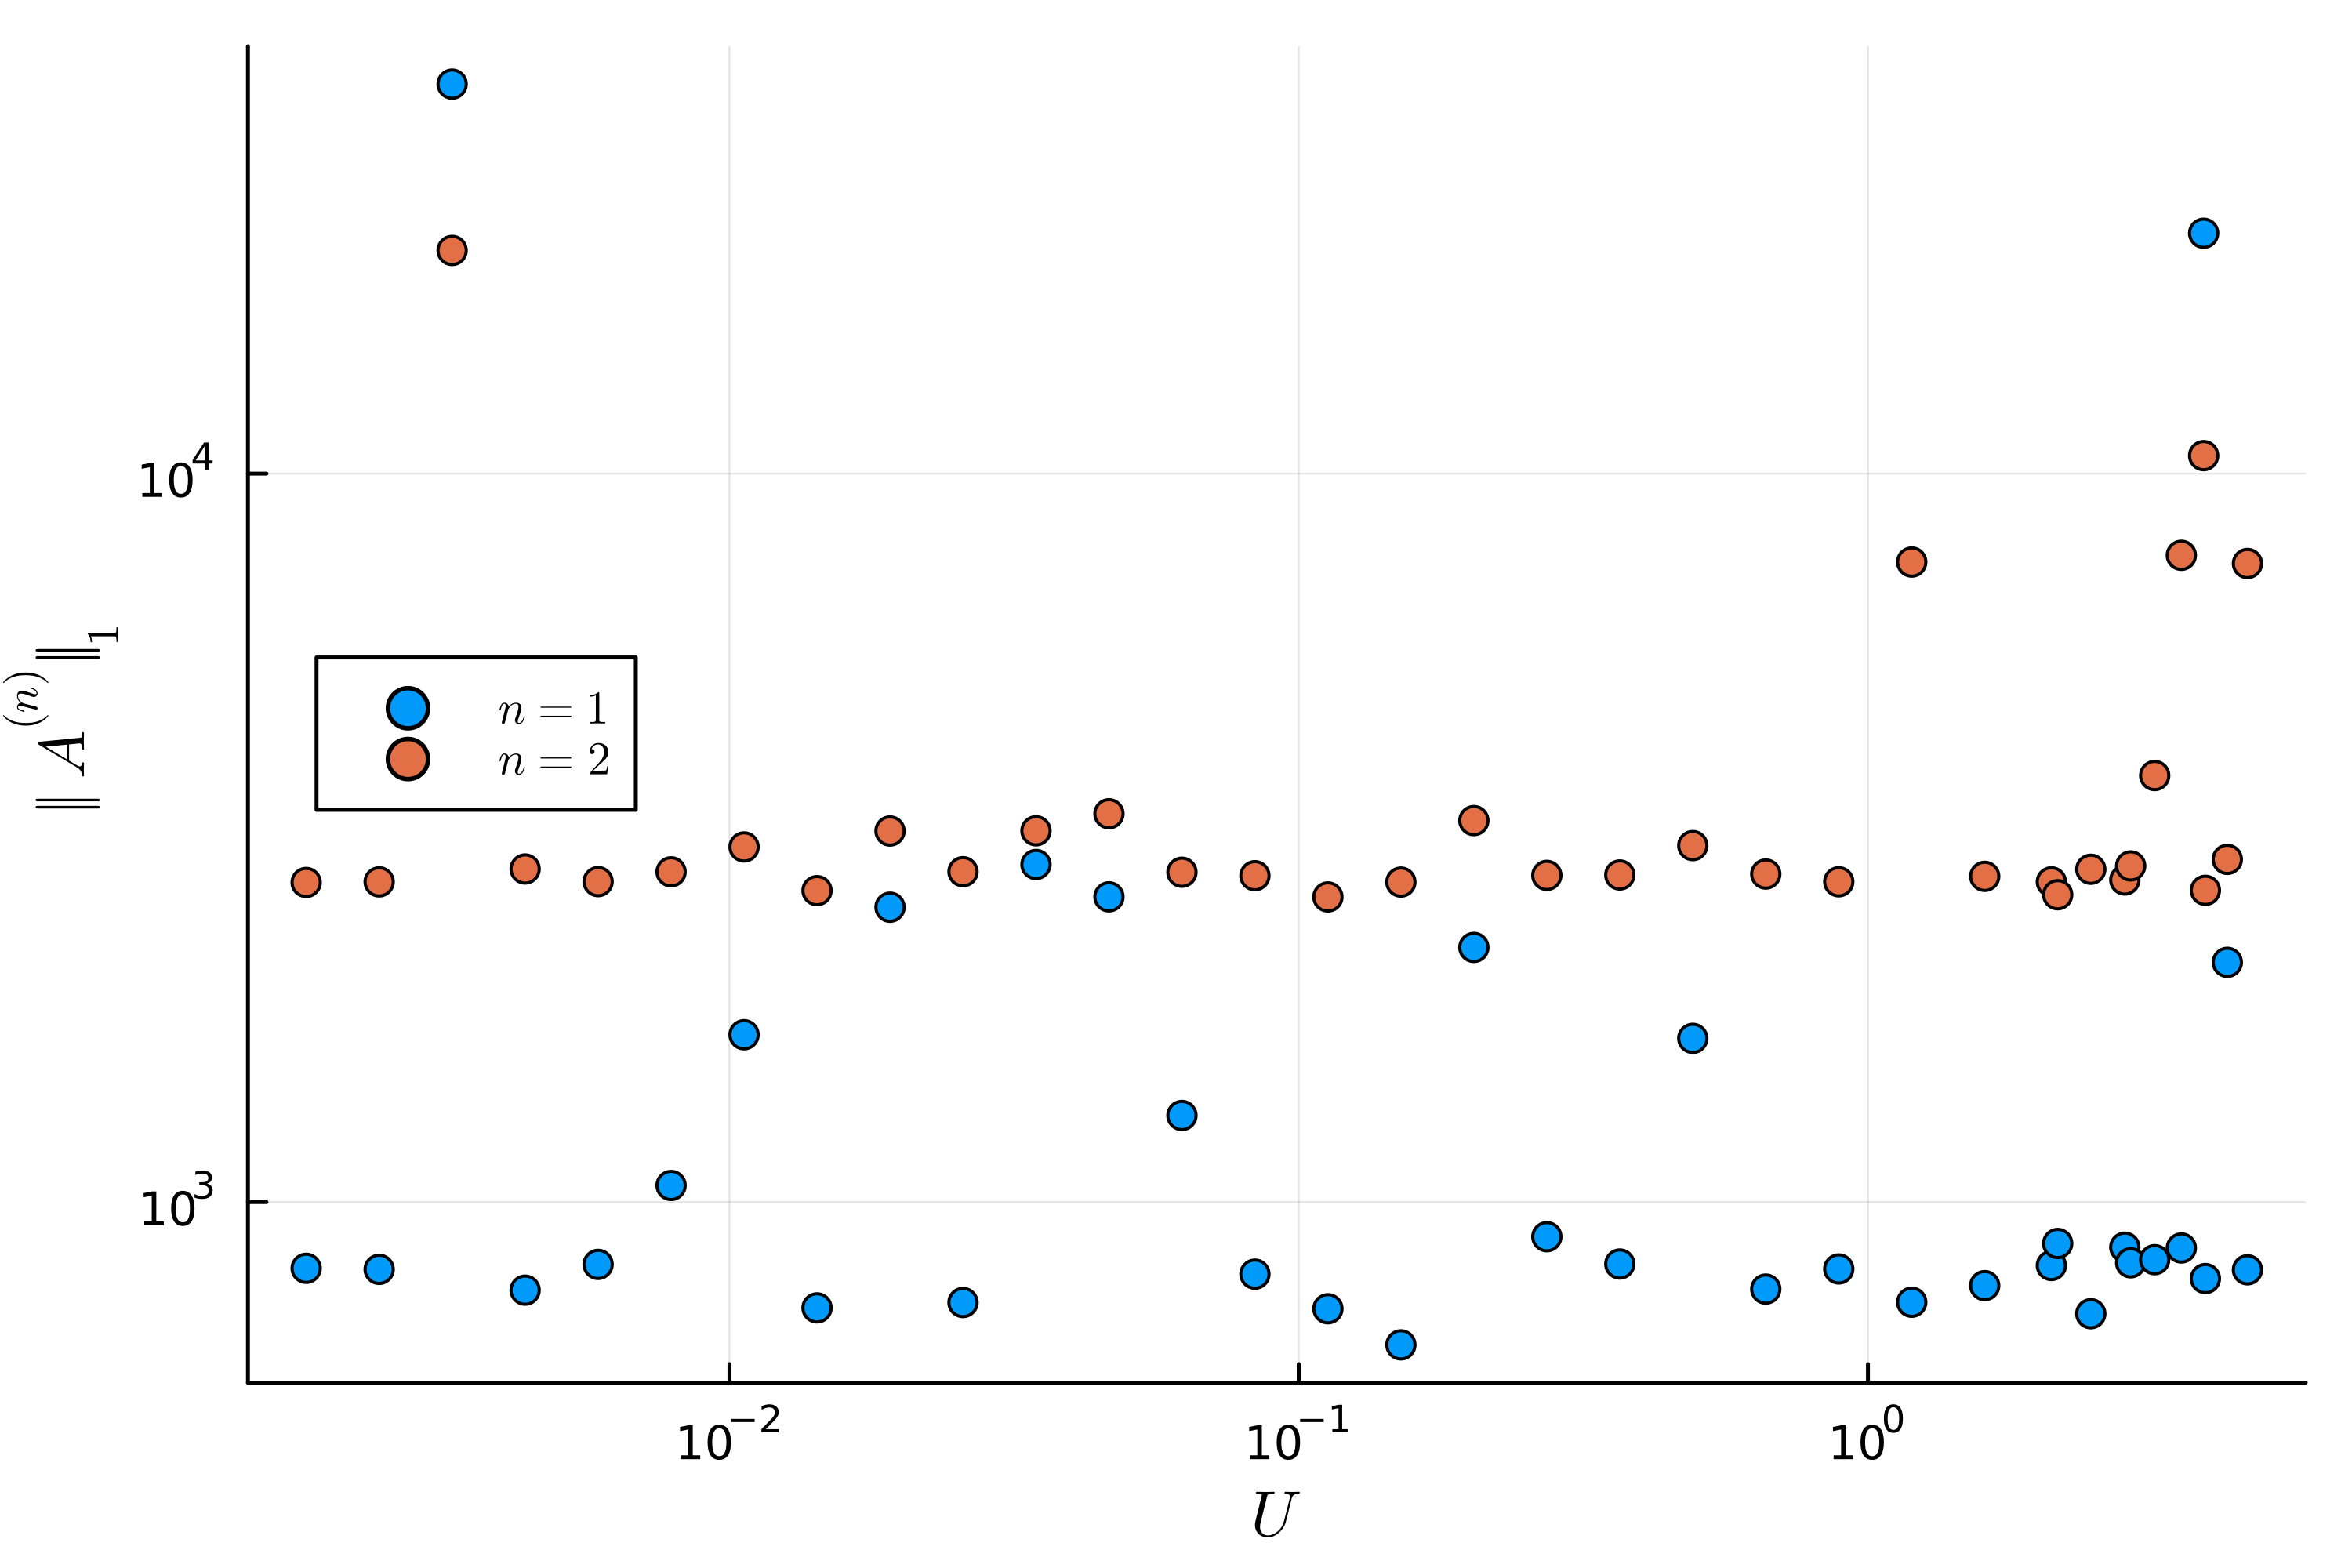

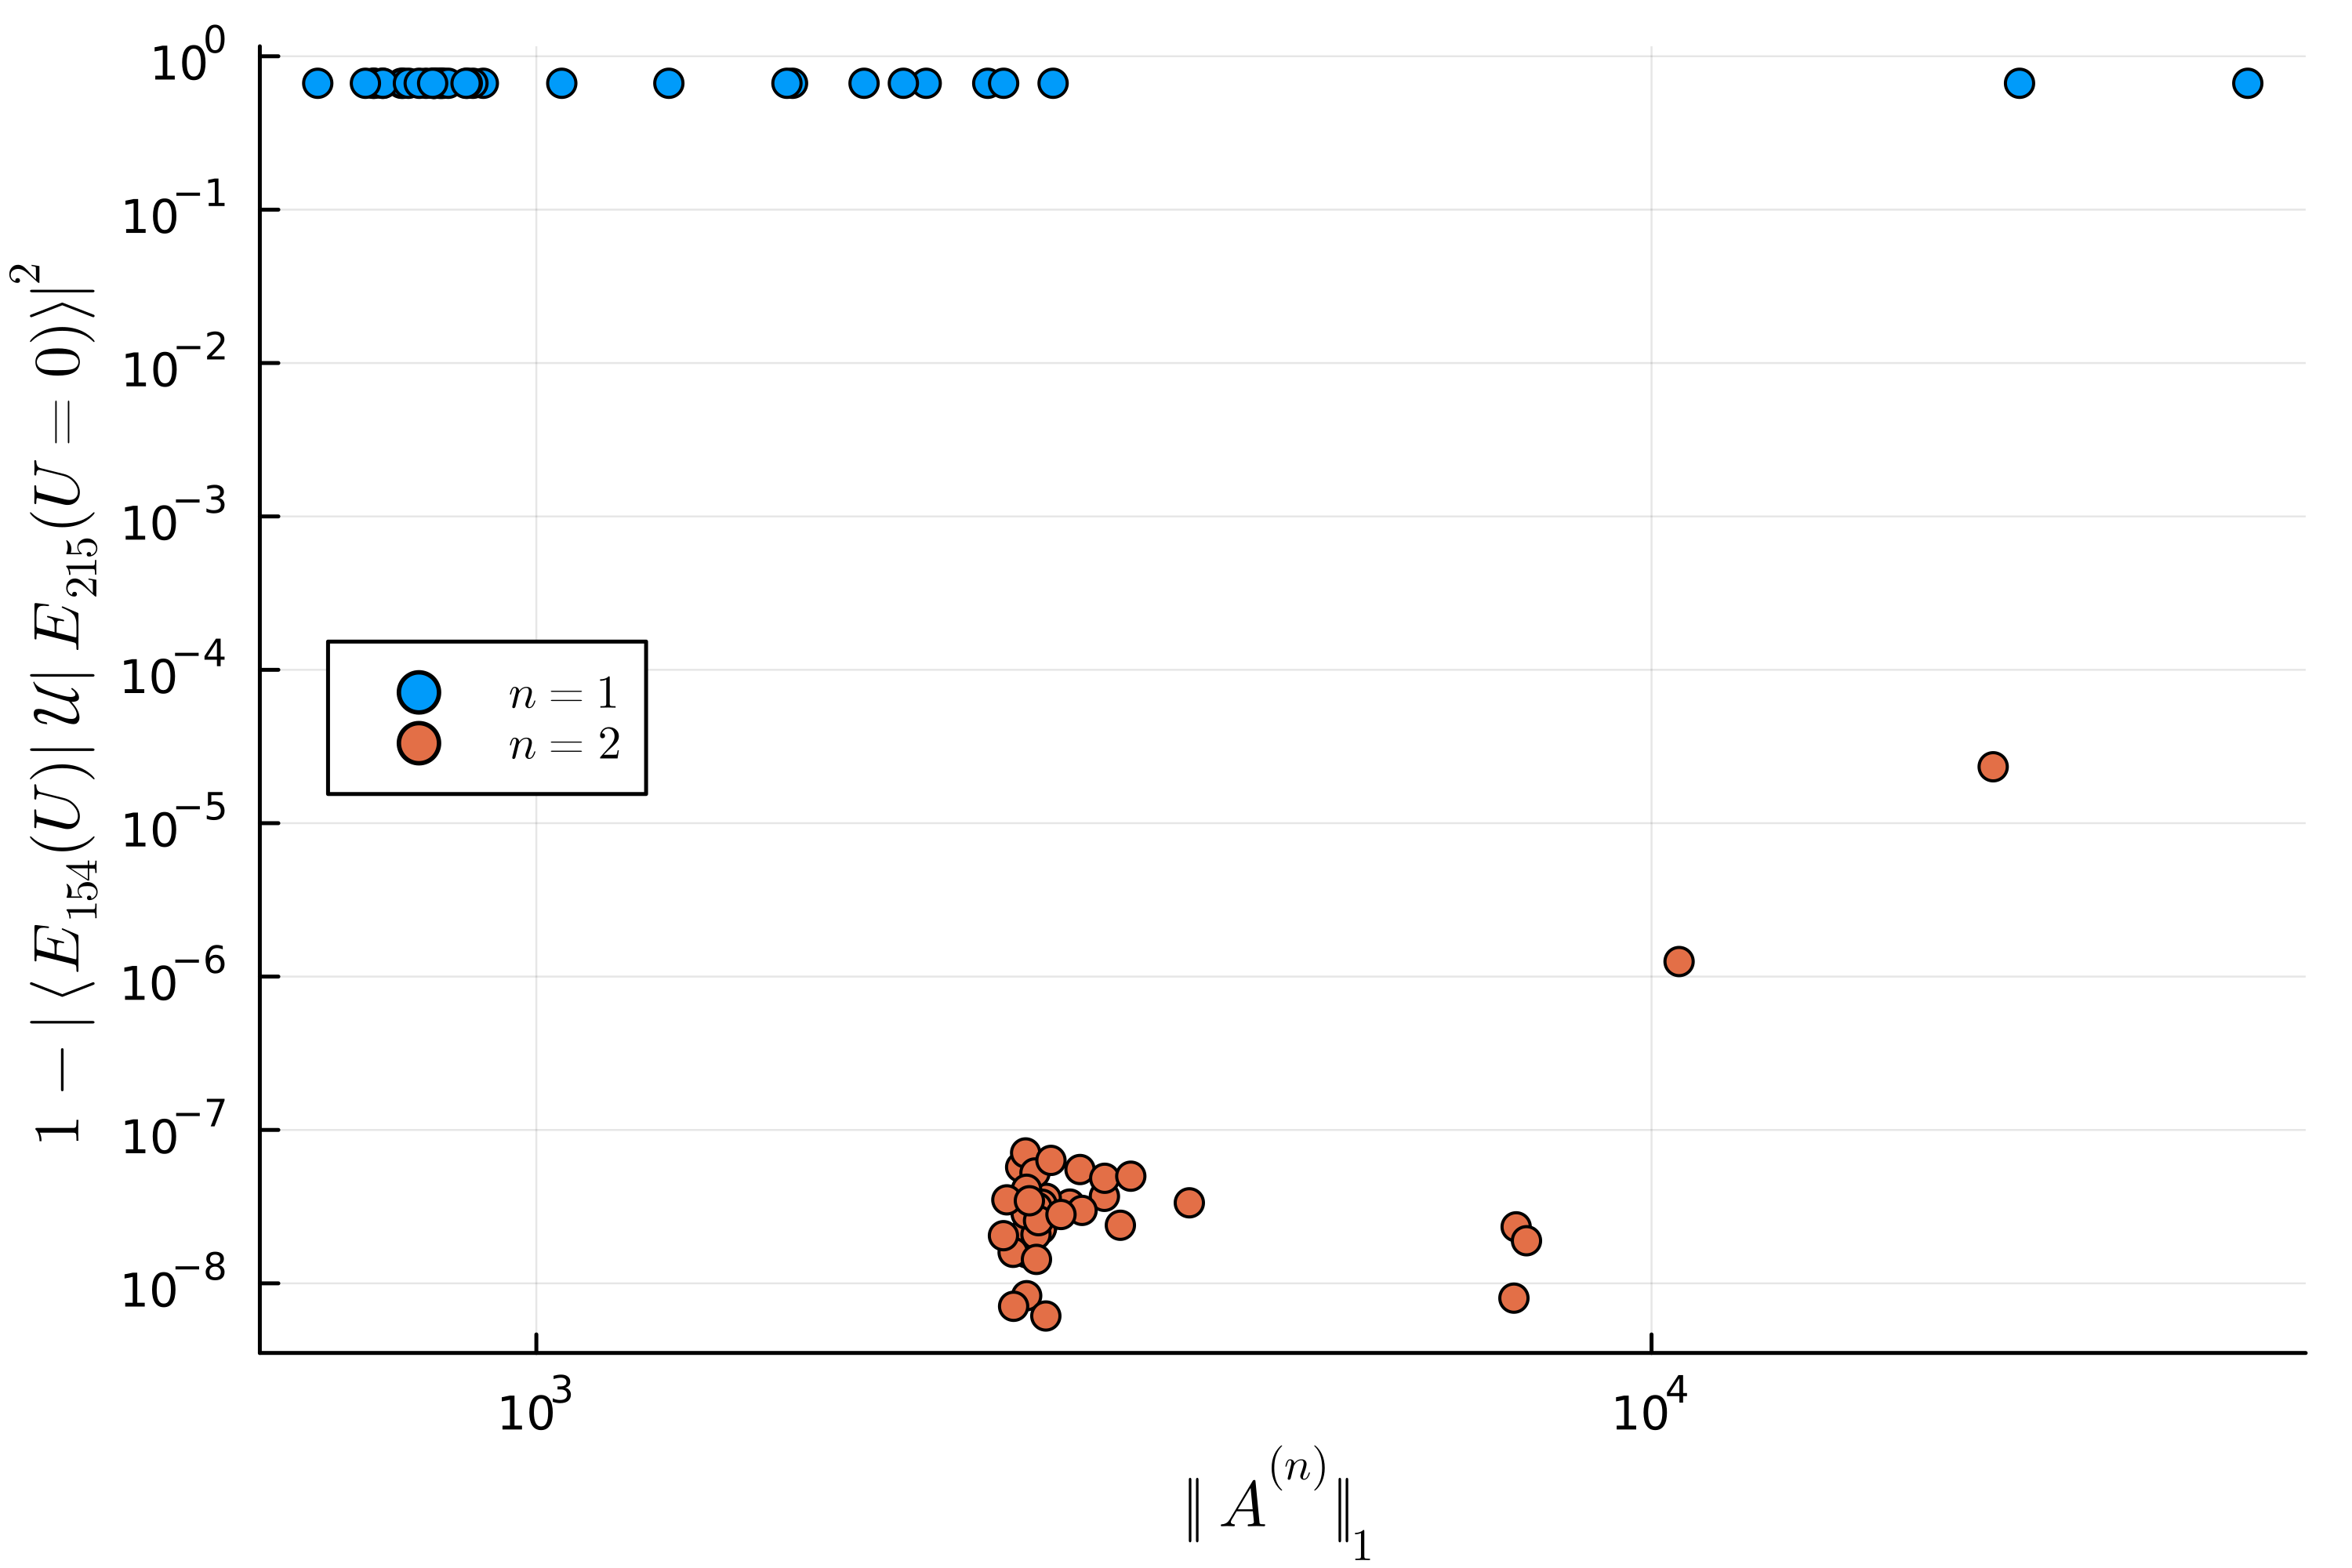

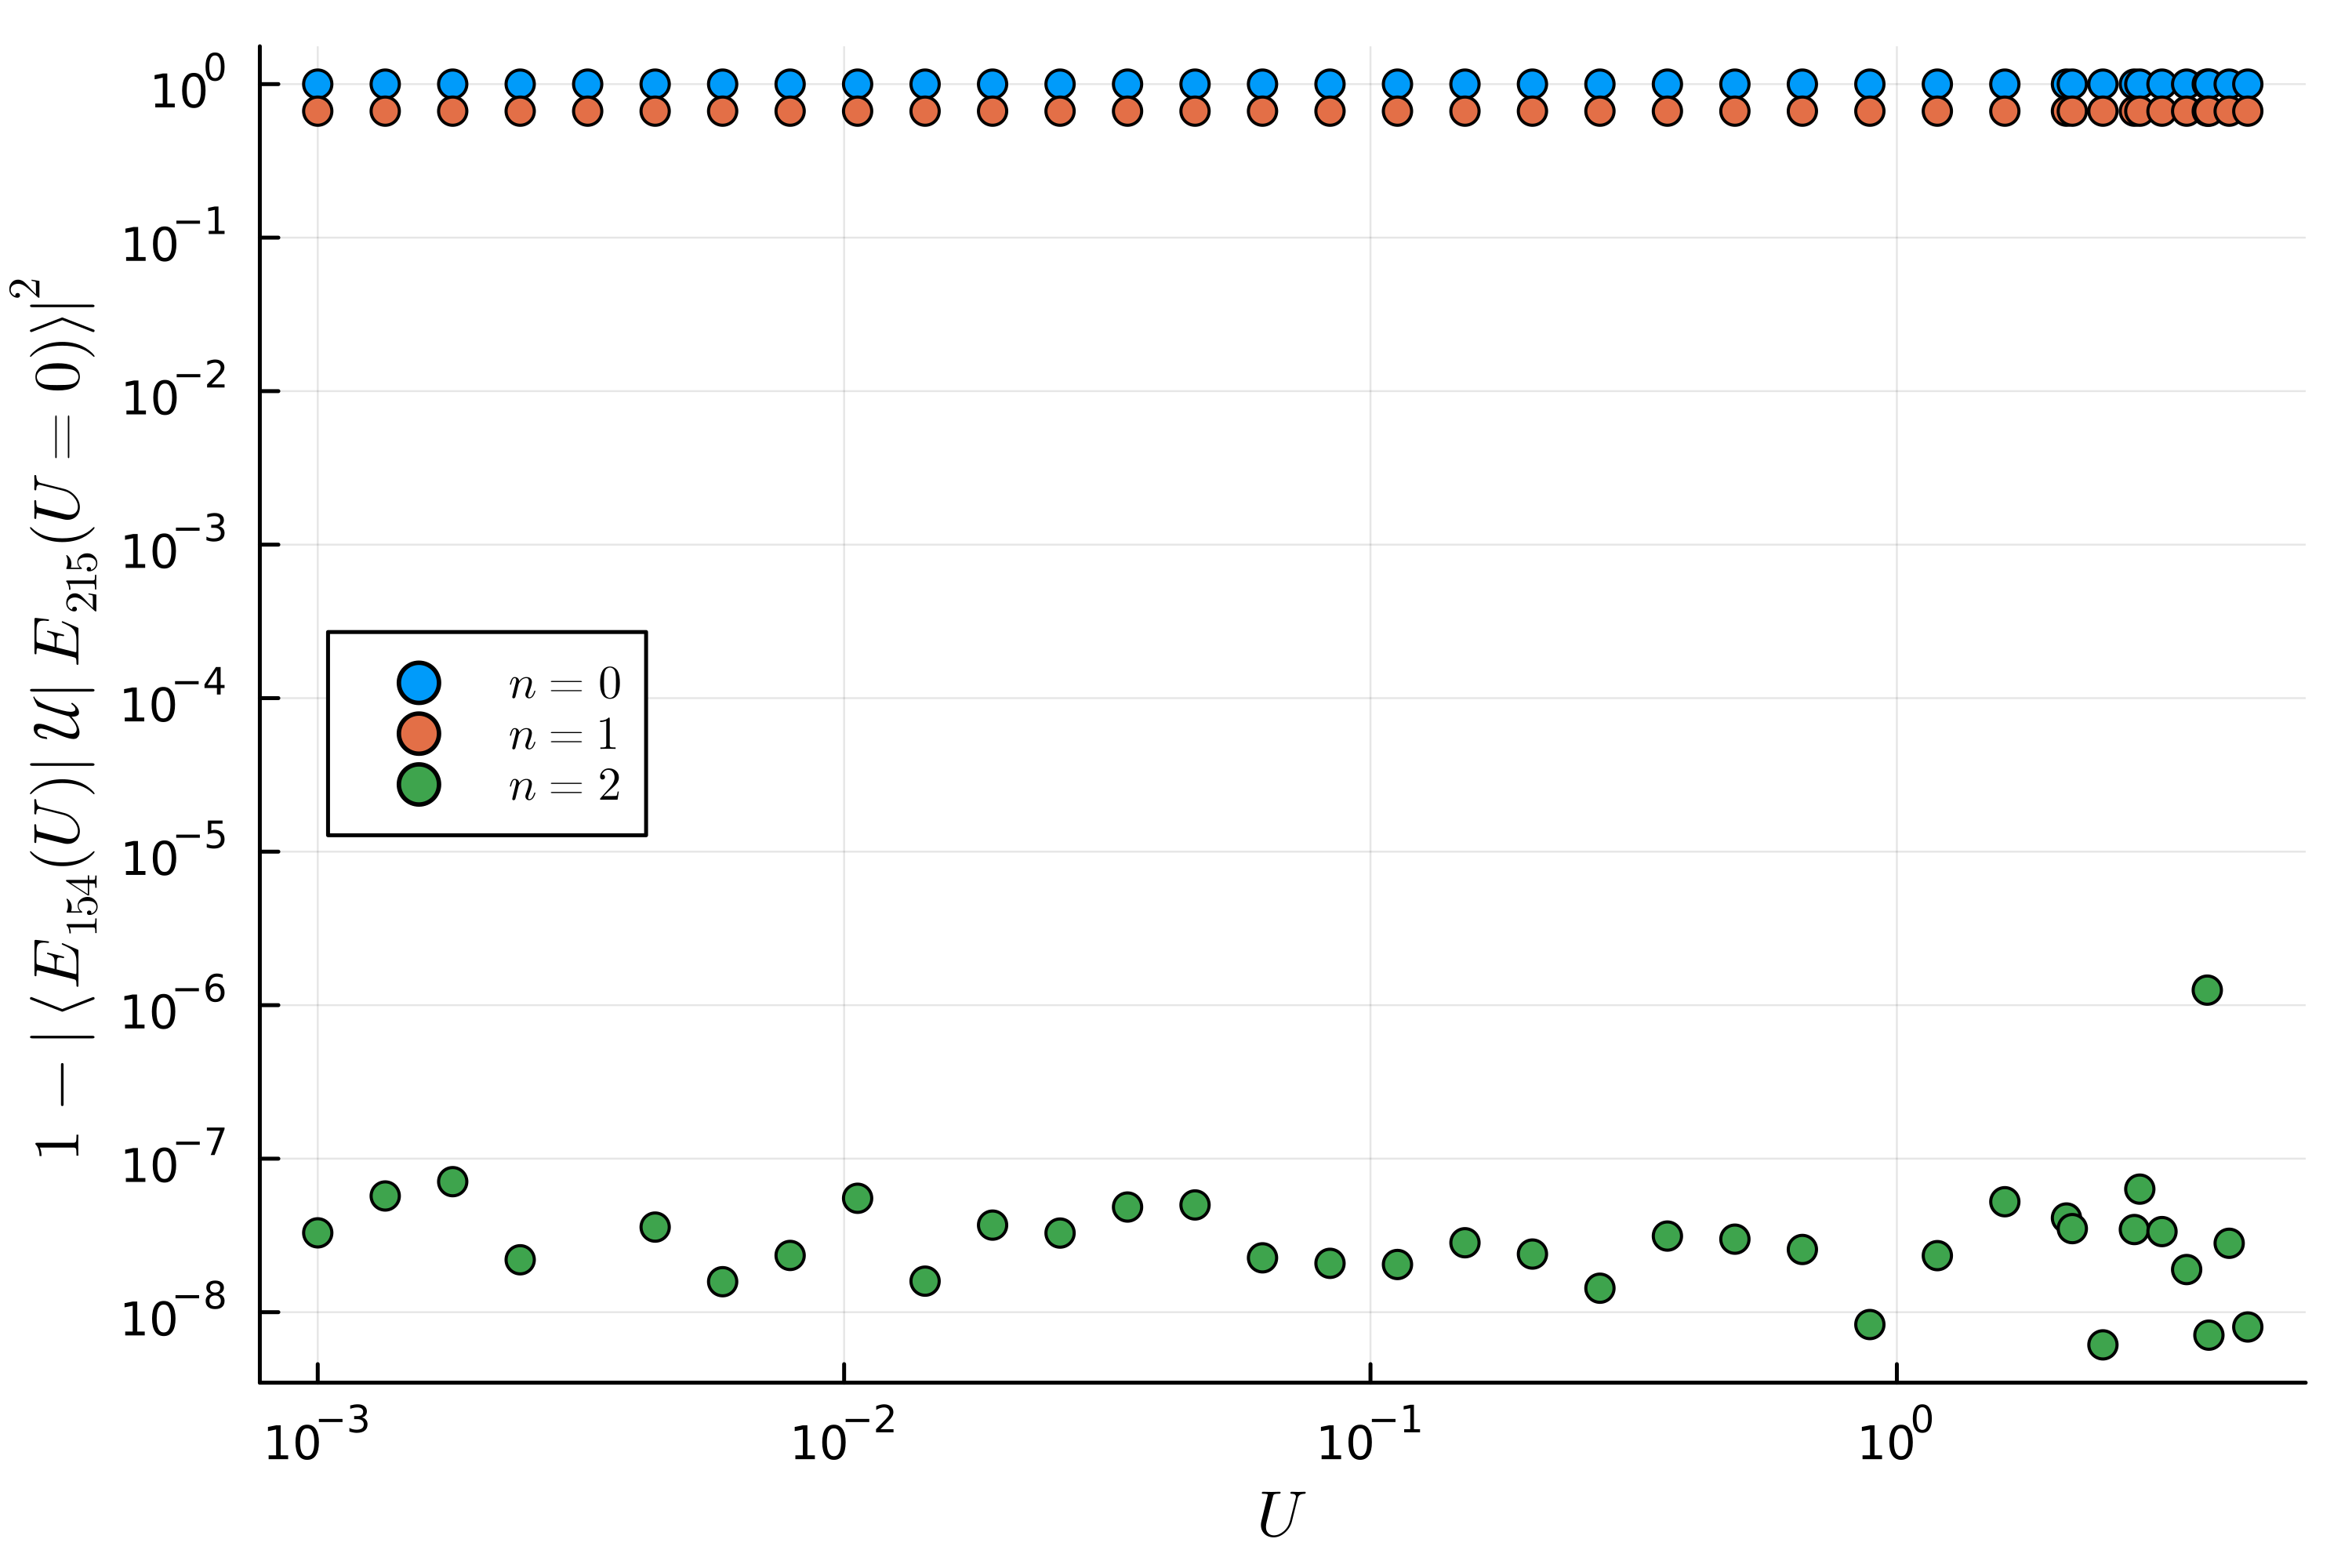

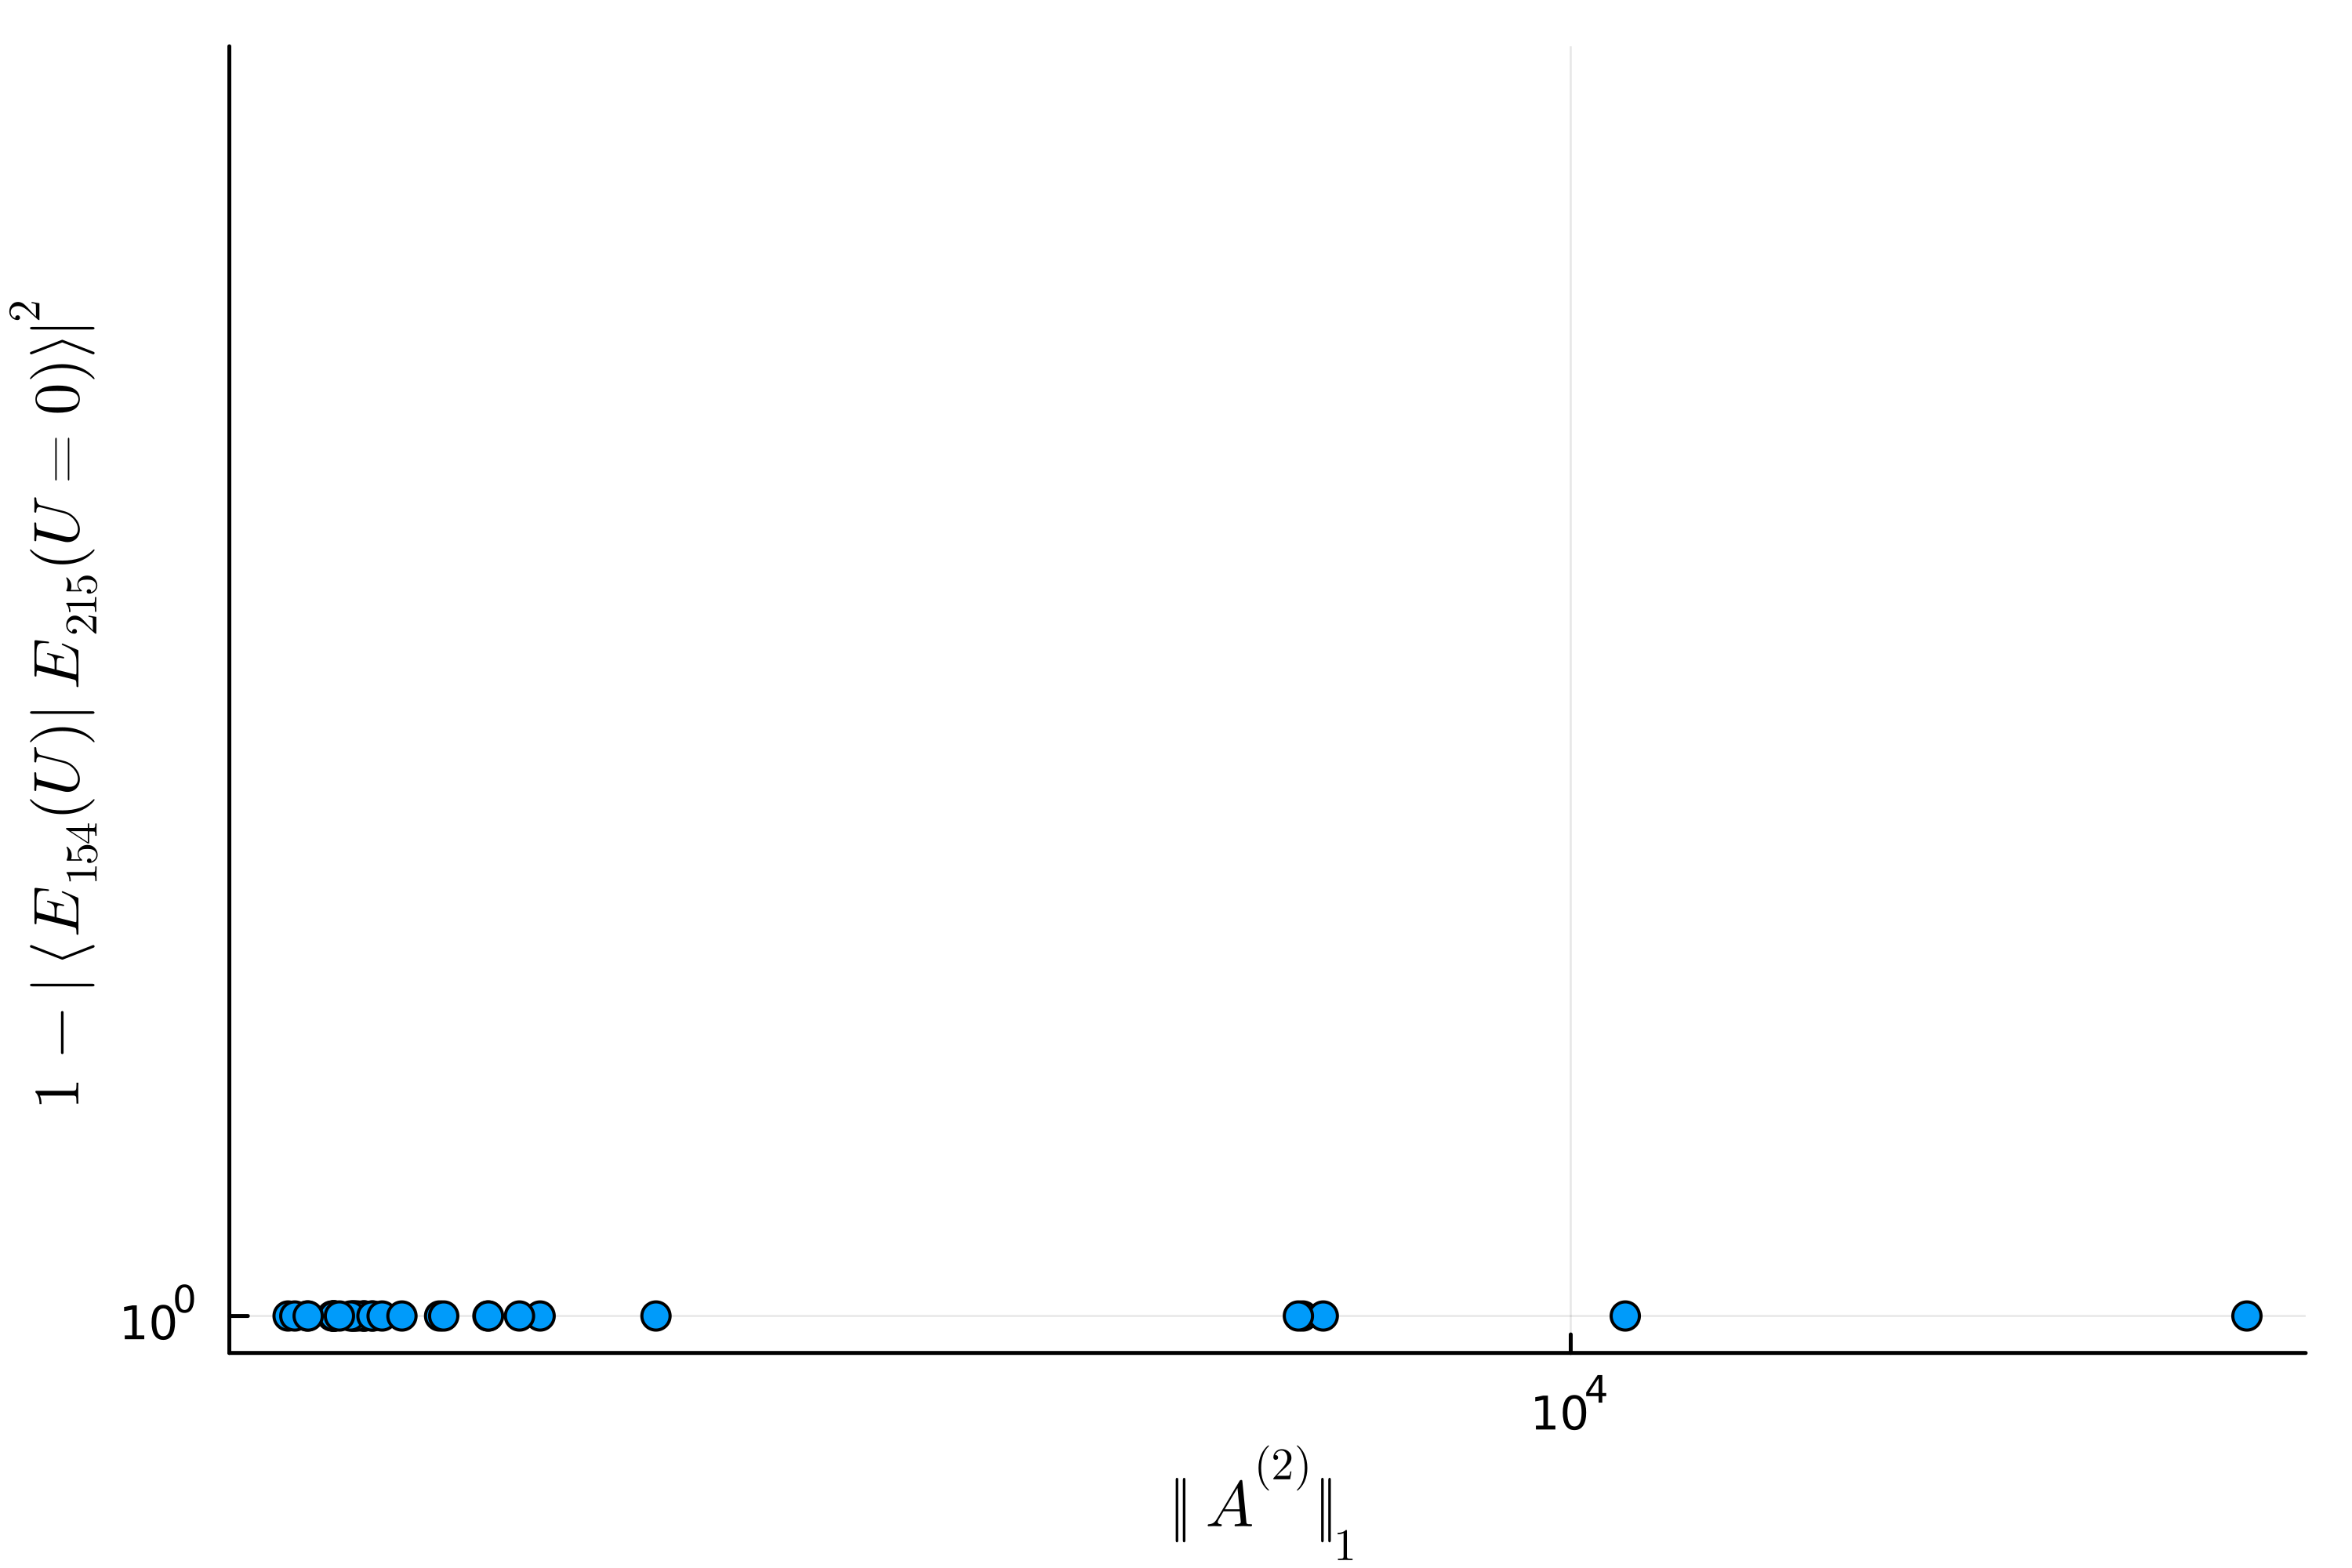

In [80]:
using Glob
n_electrons = 3
target_starting_level = 8
target_ending_level = 5



i = 60
energy_i_map = sortperm(real.(diag(degen_rm_U[i]'*H[i]*degen_rm_U[i])))
inv_map = sortperm(energy_i_map)
legend_location = :left
# p1 = plot(legend=nothing, xlabel=L"U",yscale=:log10,xticks=10.0 .^(-10:10),yticks=10.0 .^(-10:10), xscale=:log10, 
#         ylabel=L"\Vert A^{(2)}\Vert_1",dpi=500)
p1 = plot(legend=legend_location, xlabel=L"U",yscale=:log10,xticks=10.0 .^(-10:10),yticks=10.0 .^(-10:10), xscale=:log10, 
         ylabel=L"\Vert A^{(n)}\Vert_1",dpi=500)
p2 = plot(legend=legend_location, ylabel=L"1-|\langle E_{%$(inv_map[target_ending_level])}(U) |\mathcal{U}|E_{%$(inv_map[target_starting_level])}(U=0)\rangle|^2",yscale=:log10, xscale=:log10,
     yticks=10.0 .^(-10:10),xticks=10.0 .^(-10:10),xlabel=L"\Vert A^{(n)}\Vert_1",dpi=500)
p3 = plot(legend=legend_location, ylabel=L"1-|\langle E_{%$(inv_map[target_ending_level])}(U) |\mathcal{U}|E_{%$(inv_map[target_starting_level])}(U=0)\rangle|^2",yscale=:log10, xscale=:log10,
     yticks=10.0 .^(-10:10),xticks=10.0 .^(-10:10),xlabel=L"U",dpi=500)
p4 = plot(legend=nothing, ylabel=L"1-|\langle E_{%$(inv_map[target_ending_level])}(U) |E_{%$(inv_map[target_starting_level])}(U=0)\rangle|^2",yscale=:log10, xscale=:log10,
     yticks=10.0 .^(-10:10),xticks=10.0 .^(-10:10),xlabel=L"\Vert A^{(2)}\Vert_1",dpi=500)
initial_loss = []
# folder = glob"single_particle_equal_state_interaction_unitary_tests*"
# folder = glob"*"



folder = glob"unitary_map_N=3_1"
for i = 1:2
    norm_list = []
    U_values = []
    losses = []
    for path in readdir(folder, "data")
        data_dict3 = load_json_folder(path)
        if data_dict3["meta_data"]["electron count"] != n_electrons
            continue
        end
        for (label, v, loss) in zip(data_dict3["labels"], data_dict3["norm1_metrics"], data_dict3["loss_metrics"])
            if (length(v) < 2 || label["starting state"]["level"] != target_starting_level ||
                 label["ending state"]["level"] != target_ending_level
                #  || label["starting state"]["level"] == label["ending state"]["level"]
                 )
                continue
            end
            # println(label["starting state"]["level"], " ", label["ending state"]["level"])
            push!(norm_list, v[i])
            push!(U_values, data_dict3["meta_data"]["U_values"][label["ending state"]["U index"]])
            push!(losses, loss[1+i])
            if i == 1
                push!(initial_loss, loss[1])
            end
            # if length(v) >= 2
            #     println("$(label["starting state"]["level"]) $(v[2])")
            # else
            #     println("$(label["starting state"]["level"]) 0")
            # end
        end
    end
    j = sortperm(U_values)
    # peak_i = argmax(diff(y[j]))
    # println(U_values[j][peak_i])
    if i == 1
        scatter!(p3, U_values[j], initial_loss[j], label=L"n=0")
    end
    # if i == 2
        scatter!(p1, U_values[j][3:end], norm_list[j][3:end], label=L"n=%$i")
    # end
    scatter!(p2, norm_list[j], losses[j], label=L"n=%$i")
    scatter!(p3, U_values[j], losses[j], label=L"n=%$i")
    if i == 2
        scatter!(p4, norm_list[j][3:end], initial_loss[j][3:end])
    end
end

for p in [p1, p2, p3, p4]
    # if p != p2
    #     vline!(p,[5], c="black", linestyle=:dash, label=L"U=5")
    # end
    display(p)
end
variation = "random" #target_starting_level#"random"
for filetype in ["png", "svg", "pdf"]
    savefig(p1, "single_state_map_images/U_norm1_$variation.$filetype")
    savefig(p2, "single_state_map_images/loss_norm1_$variation.$filetype")
    savefig(p3, "single_state_map_images/U_loss_$variation.$filetype")
    savefig(p4, "single_state_map_images/overlap_comparison_$variation.$filetype")
end